In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary_adaptive, cy_grape_unitary
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [3]:
from qutip import *
from qutip.control import *

In [4]:
# Target Gate
U = swap()
# Number of GRAPE iterations
R = 500      

# Drift Hamiltonian
H0 = 0 * np.pi * (tensor(sigmax(), identity(2)) + tensor(identity(2), sigmax()))

#  H_ops: list of Qobj - A list of operators that can be tuned in the Hamiltonian via the control fields.
H_ops = [tensor(identity(2),identity(2)),
         tensor(sigmax(), sigmax()) ,
         tensor(sigmay(), sigmay()),
         tensor(sigmaz(), sigmaz())]

H_labels = [r'$u_{11}$',
            r'$u_{xx}$',
            r'$u_{yy}$',
            r'$u_{zz}$',
        ]

<ipython-input-4-c84b3062c50d>:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U = swap()


In [30]:
T =2*np.pi
times = np.linspace(0, T, 500)

In [ ]:
# Initialising Control fields
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))])
u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

u_limits = None 
alpha = None

In [32]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi*1, alpha=alpha, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time: 125.16s. Est. time left: 00:00:18:46
20.0%. Run time: 255.60s. Est. time left: 00:00:17:02
30.0%. Run time: 382.76s. Est. time left: 00:00:14:53
40.0%. Run time: 502.02s. Est. time left: 00:00:12:33
50.0%. Run time: 635.29s. Est. time left: 00:00:10:35
60.0%. Run time: 764.65s. Est. time left: 00:00:08:29
70.0%. Run time: 891.45s. Est. time left: 00:00:06:22
80.0%. Run time: 1022.84s. Est. time left: 00:00:04:15
90.0%. Run time: 1160.36s. Est. time left: 00:00:02:08
Total run time: 1300.87s


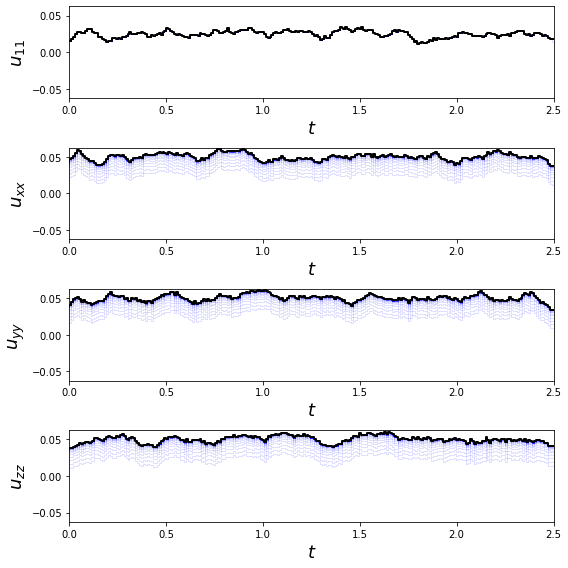

In [33]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);

In [34]:
# Fidelity/overlap

In [35]:
U

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

In [36]:
result.U_f

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 3.88562813e-01-9.21422238e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -9.75781955e-19-5.25838054e-18j]
 [ 0.00000000e+00+0.00000000e+00j  7.42461648e-16+4.43872369e-16j
   3.88562813e-01-9.21422238e-01j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  3.88562813e-01-9.21422238e-01j
  -1.10068205e-15-4.11779985e-16j  0.00000000e+00+0.00000000e+00j]
 [-1.72388145e-17-9.26992857e-18j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.88562813e-01-9.21422238e-01j]]

In [37]:
result.U_f/result.U_f[0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]

In [38]:
_overlap(U, result.U_f), abs(_overlap(U, result.U_f))

((0.3885628133614324-0.9214222376699206j), 0.9999999999999974)

In [39]:
# Test numerical integration of GRAPE pulse

In [40]:
c_ops=[]
U_f_numerical = propagator(result.H_t, t=times,c_ops=c_ops, options=Odeoptions(nsteps=5000), args={})
U_f_numerical[-1]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[3.88344626e-01-9.21514217e-01j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 4.47770723e-06+1.91939679e-06j]
 [0.00000000e+00+0.00000000e+00j 3.26497530e-04+1.37662366e-04j
  3.88602253e-01-9.21405537e-01j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 3.88602253e-01-9.21405537e-01j
  3.26497530e-04+1.37662366e-04j 0.00000000e+00+0.00000000e+00j]
 [4.47770723e-06+1.91939679e-06j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 3.88344626e-01-9.21514217e-01j]]

In [41]:
U_f_numerical[-1] / U_f_numerical[-1][0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -2.98578879e-08+4.87165829e-06j]
 [ 0.00000000e+00+0.00000000e+00j -6.42661359e-08+3.54332556e-04j
   9.99999898e-01+2.79611800e-04j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  9.99999898e-01+2.79611800e-04j
  -6.42661359e-08+3.54332556e-04j  0.00000000e+00+0.00000000e+00j]
 [-2.98578879e-08+4.87165829e-06j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j]]

In [42]:
_overlap(result.U_f, U_f_numerical[-1]).real, abs(_overlap(result.U_f, U_f_numerical[-1]))**2

(0.9999999541311316, 0.9999999176666535)

In [43]:
# Process tomography

In [44]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2

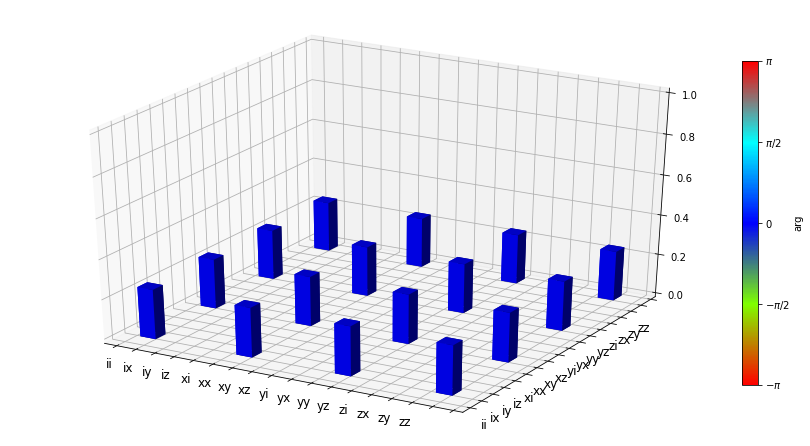

In [45]:
fig = plt.figure(figsize=(12,6))

U_i_s = to_super(U)

chi = qpt(U_i_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

In [46]:
# swap gate calculated using GRAPE

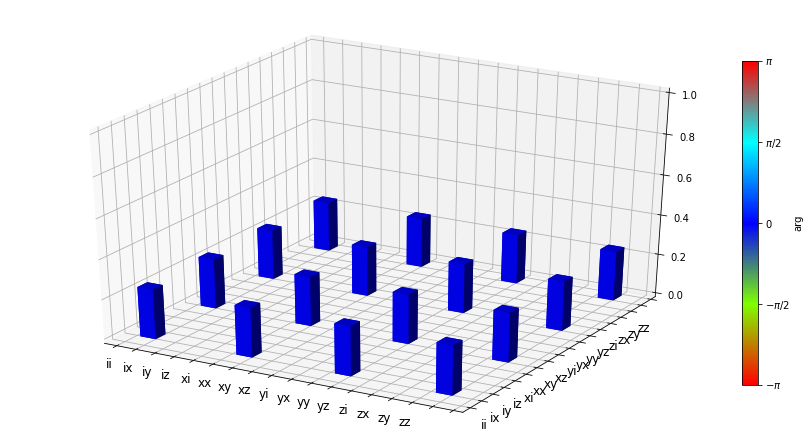

In [47]:
fig = plt.figure(figsize=(12,6))

U_f_s = to_super(result.U_f)

chi = qpt(U_f_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)